# Image classification

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Define some parameters for the loader:

In [2]:
batch_size = 32
img_height = 64
img_width = 64
num_classes = 3

## Split Dataset (80% Training, 20% Validating)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2455 files belonging to 2 classes.
Using 1964 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2455 files belonging to 2 classes.
Using 491 files for validation.


## Show class name

In [5]:
class_names = train_ds.class_names
print(class_names)

['Not_Papaya', 'Papaya']


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.048465267 0.93633586


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Data augmentation

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Build model

In [23]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)       

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
62/62 [==============================] - 4s 60ms/step - loss: 0.3457 - accuracy: 0.8483 - val_loss: 0.1771 - val_accuracy: 0.9348
Epoch 2/20
62/62 [==============================] - 4s 57ms/step - loss: 0.2460 - accuracy: 0.9119 - val_loss: 0.4095 - val_accuracy: 0.8921
Epoch 3/20
62/62 [==============================] - 4s 57ms/step - loss: 0.2132 - accuracy: 0.9175 - val_loss: 0.1718 - val_accuracy: 0.9430
Epoch 4/20
62/62 [==============================] - 4s 57ms/step - loss: 0.1892 - accuracy: 0.9292 - val_loss: 0.2573 - val_accuracy: 0.9165
Epoch 5/20
62/62 [==============================] - 4s 58ms/step - loss: 0.1980 - accuracy: 0.9236 - val_loss: 0.1881 - val_accuracy: 0.9287
Epoch 6/20
62/62 [==============================] - 4s 58ms/step - loss: 0.1889 - accuracy: 0.9297 - val_loss: 0.1841 - val_accuracy: 0.9491
Epoch 7/20
62/62 [==============================] - 4s 59ms/step - loss: 0.1688 - accuracy: 0.9414 - val_loss: 0.1463 - val_accuracy: 0.9532
Epoch 8/20
62

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

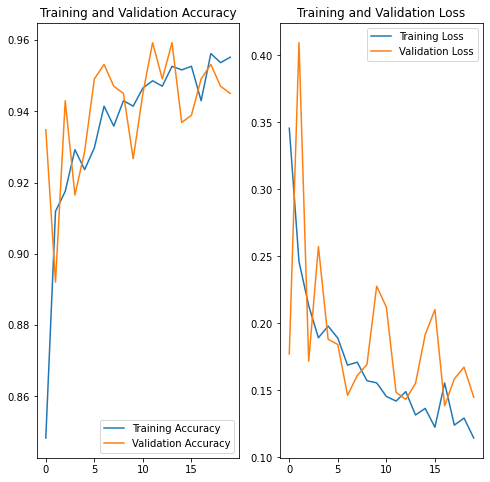

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [32]:
papaya_results=[]
for i in range(1,88):
    img = keras.preprocessing.image.load_img(
        f'Testing/Papaya {i}.png', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(f"{i}: {class_names[np.argmax(score)]}")
    papaya_results.append(class_names[np.argmax(score)])
    
# print(papaya_results)
#     print(
#         "{}: {} with a {:.2f} percent confidence."
#         .format(i,class_names[np.argmax(score)], 100 * np.max(score))
#     )

1: Papaya
2: Papaya
3: Papaya
4: Papaya
5: Not_Papaya
6: Papaya
7: Papaya
8: Papaya
9: Papaya
10: Papaya
11: Not_Papaya
12: Papaya
13: Papaya
14: Papaya
15: Papaya
16: Not_Papaya
17: Papaya
18: Papaya
19: Papaya
20: Papaya
21: Not_Papaya
22: Papaya
23: Papaya
24: Papaya
25: Not_Papaya
26: Papaya
27: Papaya
28: Papaya
29: Papaya
30: Papaya
31: Papaya
32: Papaya
33: Papaya
34: Not_Papaya
35: Papaya
36: Papaya
37: Papaya
38: Not_Papaya
39: Papaya
40: Papaya
41: Papaya
42: Papaya
43: Papaya
44: Papaya
45: Papaya
46: Papaya
47: Papaya
48: Papaya
49: Papaya
50: Papaya
51: Not_Papaya
52: Not_Papaya
53: Not_Papaya
54: Papaya
55: Papaya
56: Papaya
57: Papaya
58: Papaya
59: Papaya
60: Papaya
61: Papaya
62: Papaya
63: Papaya
64: Papaya
65: Papaya
66: Papaya
67: Papaya
68: Papaya
69: Papaya
70: Papaya
71: Papaya
72: Papaya
73: Papaya
74: Papaya
75: Papaya
76: Papaya
77: Papaya
78: Papaya
79: Not_Papaya
80: Papaya
81: Papaya
82: Papaya
83: Papaya
84: Not_Papaya
85: Papaya
86: Papaya
87: Papaya


In [33]:
not_papaya_results=[]
for i in range(1,258):
    img = keras.preprocessing.image.load_img(
        f'Testing/Not Papaya/not_papaya ({i}).jpg', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    not_papaya_results.append(class_names[np.argmax(score)])
#     print(
#         "{}: {} with a {:.2f} percent confidence."
#         .format(i,class_names[np.argmax(score)], 100 * np.max(score))
#     )

print(not_papaya_results)

['Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_Papaya', 'Not_

In [34]:
err = 0
for i in papaya_results:
    if i=='Not_Papaya':
        err+=1
for i in not_papaya_results:
    if i=='Papaya':
        err+=1
print(err)

13


In [35]:
model.save("isPapaya_round4_13_mispapaya.h5")